In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import requests 
import nltk
from nltk.probability import FreqDist
from nltk.corpus import gutenberg
from nltk.corpus import stopwords

# Intro

When considering a dataset to analyze, my brain went to the Vsauce video "The Zipf Mystery" (https://www.youtube.com/watch?v=fCn8zs912OE), and specifically the list of word frequencies from wikipedia and the Gutenberg corpus. I honed in on wanting to analyze the Gutenberg corpus in some way, and in my search I found the python module NLTK - "Natural Language Toolkit", which has inbuilt corpora, including a selection from Project Gutenberg. The data is available at https://www.nltk.org/nltk_data/. If you're unfamiliar, Project Gutenberg is a collection of thousands of public domain books in digital format, and a corpus is simply a collection of words, in this case the words are from the selection of texts from Project Gutenberg.

# All Words at Once

The details of which texts are included in the selection will be covered later, but first we should get an overview of our corpus. The most straightforward first step is to simply count the frequency of each word, so I'll use regular expressions to count the frequenc, and the make a barplot of the 50 most common words.
The most straightforward way to analyze a collection of words is to simply count the frequency of each word. Let's plot the 50 most common words in our dataset.

In [2]:
# I make a dataframe using the FreqDist funciton from nltk,
# filtering out all punctuation from the word list with a regular expression
counts = pd.DataFrame( columns = ["word","count"],
    data = FreqDist(\
        filter \
            (lambda x: re.match(r"[A-Za-z]+",x),
            gutenberg.words())).items())

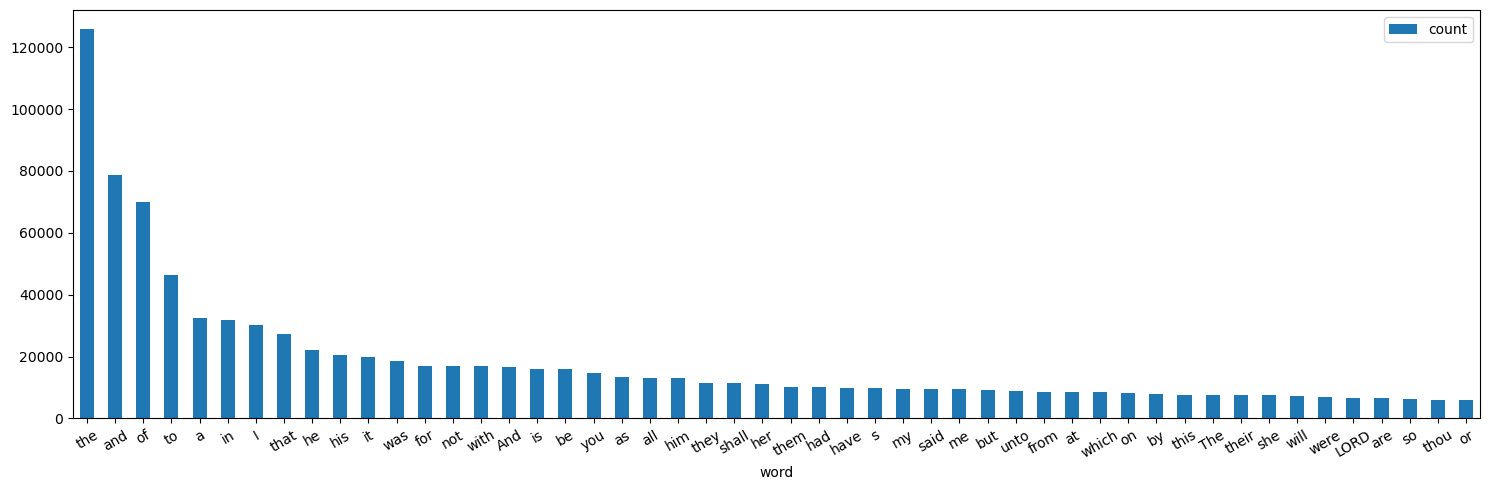

In [3]:
fig, ax = plt.subplots(figsize = (15,5))
counts.sort_values(ascending = False, by  = "count").head(50).plot.bar(x = "word", y = "count", rot = 30, ax = ax)
fig.tight_layout()

The most common word is "the" as it is for most texts in the english language. You'll notice that the vast majority of words in the plot are not nouns, adjectives, or verbs. Instead, they are the "glue" words of english such as prepositions, determiners, and pronouns. This makes sense as nouns refer to specific people and things, which requires that thing to be relevant to the text, but "glue" words are more generally applicable. 

This plot also shows a few flaws in the code used to count the word frequency. The `.words()` method i used to get a list of all the words in our dataset does not account for if the word is capitalised or not, and so we have words that appear multiple times, such as "and" and "And" aswell as "the" and "The". Though this also gives us some insight such as, since uncapitalised "the" is more frequent that uncapitalised "and", but the opposite is true for the capitalised versions, we can conclude that "and" is more likely to appear at the start of sentances than "the" is.

Another flaw that highlighted here is the appearance of the word "s". This comes from the breaking up of contractions such as "it's" and "let's". Since the "s" refers to different words depending on the contraction (or even no word at all if it signifies possession!), we don't know what data might be held within.

While getting the data that "s" holds would require more sophisticated methods, making all the words lowercase before counting them is simple!

In [4]:
# Here i apply the function .lower() to uncapitalize all the words before they are counted
counts_lower = pd.DataFrame( columns = ["word","count"],                            
    data = FreqDist( word.lower() for word in \
        filter \
            (lambda x: re.match(r"[A-Za-z]+",x),
            gutenberg.words())).items())

If we count the words that appear in this uncapitalised version and not the capitalised one, we find only two words.

In [5]:
cap_words = [word.lower() for word in counts.sort_values(ascending = False, by = "count").head(50)["word"].values]
low_words = [word for word in counts_lower.sort_values(ascending = False, by = "count").head(50)["word"].values]
[x for x in low_words if x not in cap_words]

['there', 'when']

By plotting our new lowercase counts, we can see where these words appear.

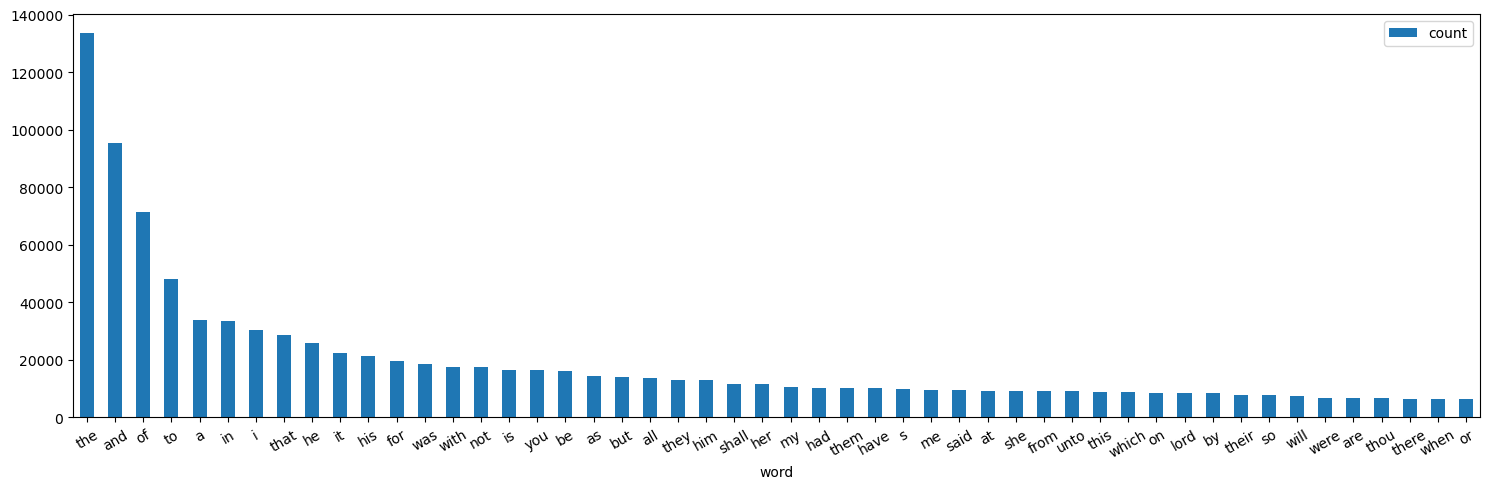

In [6]:
fig, ax = plt.subplots(figsize = (15,5))
counts_lower.sort_values(ascending = False, by  = "count").head(50).plot.bar(x = "word", y = "count", rot = 30, ax = ax)
fig.tight_layout()

We see that "there" and "when" appear at the end of the plot, but noticably, before "or", which in the previous plot also was at the end. Our new words, created by combining the counts of their capitalised and uncapitalised forms, have overtaken another word, showing us that uncapitalising our words definitely has importance for our data. We also see some other small differences in the plots such as "and" taking a bigger lead over third place, and a few words swapping places.

# Words by Author and Title

Something i neglect to mention in the earlier plot is the appearance of some unusual vocabulary. Specifically the words "lord" and "thou". These words are unusual in a modern context, and would be unexpected if we were working with the entire gutenberg corpus, but our dataset is only a small subset of texts. Thus, the appearance of these rare and unusual words in the top 50 must be a bias from the specific selection of texts we have.

The Selection from https://www.nltk.org/nltk_data/ contains a README file detailing the authors behind the included texts, including Jane Austen, William Shakespeare, and Lewis Carroll. Luckily, this information is also contained in the names of the text files themselves, which we can access like so:

In [7]:
gutenberg.fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

Since each filename includes a unique author and title combination, we can make word counts of each text seperately and attribute word use to each author and title seperately.

In [8]:
dfs = []
ids = gutenberg.fileids()
        
for s in ids:

    # search for author and title in filename
    temp = re.search("\w+", s)
    author, title = re.findall("\w+", s)[:2] # first two matches are the the author and title
    
    # kjv stands for king james version, so i make a name change, giving the book that as the title
    if title == "kjv" and author == "bible":
        title = "king james bible"
        author = "bible"
        
    # same counting code as previously, fileids = s makes the count only care about that specific text file
    count = FreqDist( word.lower() for word in \
            filter \
            (lambda x: re.match(r"[A-Za-z]+",x),
            gutenberg.words(fileids = s)))
    
    # count is a dictionary with words as keys and counts as values
    words = [x for x in count.keys()]
    counts = [x for x in count.values()]
    
    # add dataframe with counts and attributions to author and title to a list
    dfs.append(pd.DataFrame({"author" : author, "title" : title, "word" : words, "count" : counts}))
    
# concatenates the dataframes into one dataframe
df = pd.concat(dfs)

Each text has a different size, the King James Bible being the biggest of all. This is why "lord" appeared as one of the top words earlier. To more specifically analyse how word usage differs in each text, I will create collumns in the dataframe containing the percentage of words in the specific title/authors works that are that word.

In [9]:
def fraction(what,df):
    out = []

    # looks through either all authors works or a specific title and caltulates the fraction that is each word
    for s in df[what].unique():

        
        subset = df.loc[df[what] == s]               # the rows with the specific author/title
        total_count = sum(subset["count"].values)    # the total amount of words from the author/title
        
        if what == "author":
            # here we ignore what title the word comes from, so we need to count the total appearances over all works by the author
            # e.g. "said" will have the same frac_author value for all titles by that author
            for w in subset["word"]:
                total_word = sum(subset.loc[subset["word"] == w]["count"].values)
                out.append(total_word/total_count)
        else:
            # each count is divided by the total amount of words to get a fraction
            out.extend(subset["count"].values/total_count)
               
    return out
    
df["frac_author"] = fraction("author", df)
df["frac_title"] = fraction("title", df)

Here, `frac_title` is the fraction of words in the specific title that is that word, and `frac_author` is the faction of words in the authors titles that is that words, so that the same word in different titles have the same value. However, if we sort the words by their fractional appearance, we once again get the common words that most english texts have. To get a better look at the unique vocabulary of each title/author, we have to filter out these uninteresting words. Such words are called stopwords, and nltk has an inbuilt list of stopwords we can use to remove them.

In [10]:
df.sort_values(ascending = False, by = "frac_title").head()

,author,title,word,count,frac_author,frac_title
0,bible,king james bible,the,64023,0.080853,0.080853
36,whitman,leaves,the,10113,0.080086,0.080086
47,bryant,stories,the,3451,0.074007,0.074007
14,melville,moby_dick,the,14431,0.066087,0.066087
17,bible,king james bible,and,51696,0.065286,0.065286


In [11]:
clean_data = df.loc[df["word"].\
                    apply(lambda x: x not in (stopwords.words("english")))] # applying a function that only allows non-stopwords
clean_data.sort_values("frac_author", ascending = False)

,author,title,word,count,frac_author,frac_title
233,carroll,alice,said,462,0.016903,0.016903
0,carroll,alice,alice,398,0.014561,0.014561
3,burgess,busterbrown,buster,229,0.014025,0.014025
9,bryant,stories,little,597,0.012803,0.012803
92,burgess,busterbrown,little,207,0.012678,0.012678
...,...,...,...,...,...,...
9177,bible,king james bible,intermeddle,1,0.000001,0.000001
3791,bible,king james bible,kernels,1,0.000001,0.000001
11282,bible,king james bible,sheepfold,1,0.000001,0.000001
3790,bible,king james bible,moist,1,0.000001,0.000001


Now we have a set of most interesting words to analyze. Another bar plot is in order, but this time we can order the words by their fractional frequency, finding the most common words for specific authors/titles. We can even compare the authors/titles to eachother, which the following plot will do, taking the 50 most frequent based on the `frac_title` value, and color coding them to what title the value originates from.

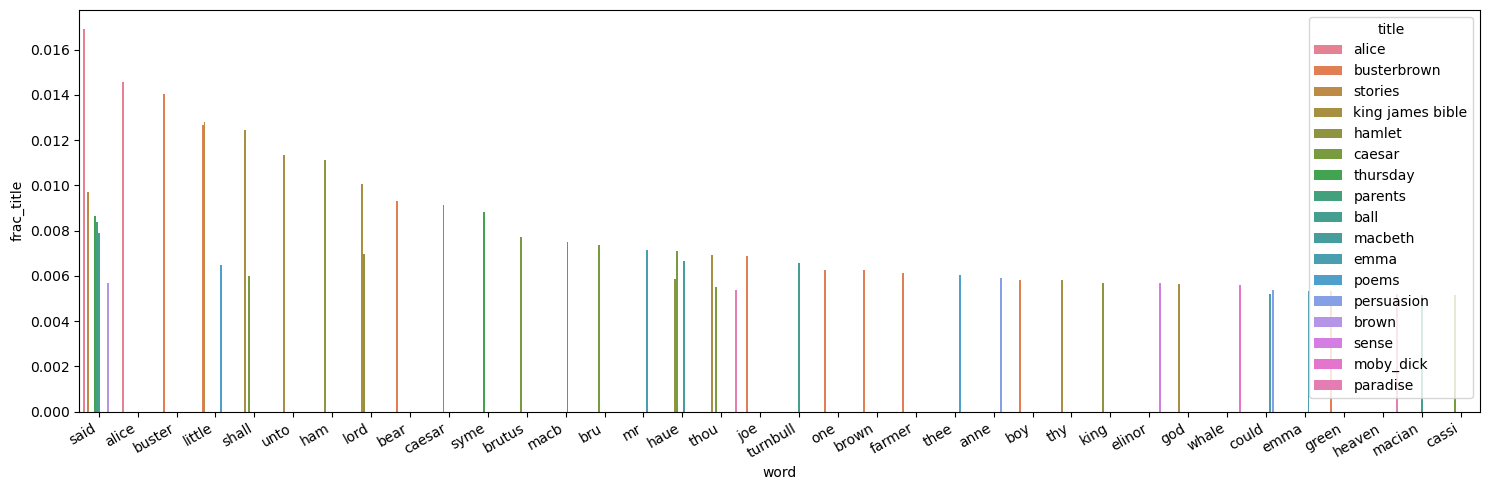

In [12]:
fig, ax = plt.subplots(figsize = (15,5))
sns.barplot(data =  clean_data.sort_values("frac_title", ascending = False).head(50), x = "word", y = "frac_title", hue = "title", ax = ax)
plt.xticks(rotation=30, ha='right')
fig.tight_layout()

We see that, by far, the most common word overall is "said", and it is especially high in Alice's Adventures in Wonderland Wonderland by Jane Austen. Such a high count of the word can be explained by Alice being very character focused, with speech therefore being very common. It it also a very common word in the other texts, with multiple entries in the top 50 being the word from different texts. Now that we have taken out stopwords, most popular words are now nouns, whether they be proper or not. The majority seem to be names . Alice from Alice's Adventures in Wonderland, Buster and Brown from The Adventures of Buster Bear, also Ceasar, Emma, Joe, Brutus, Syme, Anne. Even "ham", "bru", and "macb", which don't even seem to be names, are actually shortenings of names from Shakespeare plays, as these texts are scripts. Speaking of Shakespeare, there are also some antiquated words such as "thy", "thee" and "thou" from the King James Bible and Shakespeare, as well as an old spelling of have with "haue", that appear in the plot. The Bible and Shakespeare share multiple spots with "shall", "lord", "haue" and "thou".

Now let's make a plot based on the author instead of the title and see if there is a difference in the kinds of words that appear.

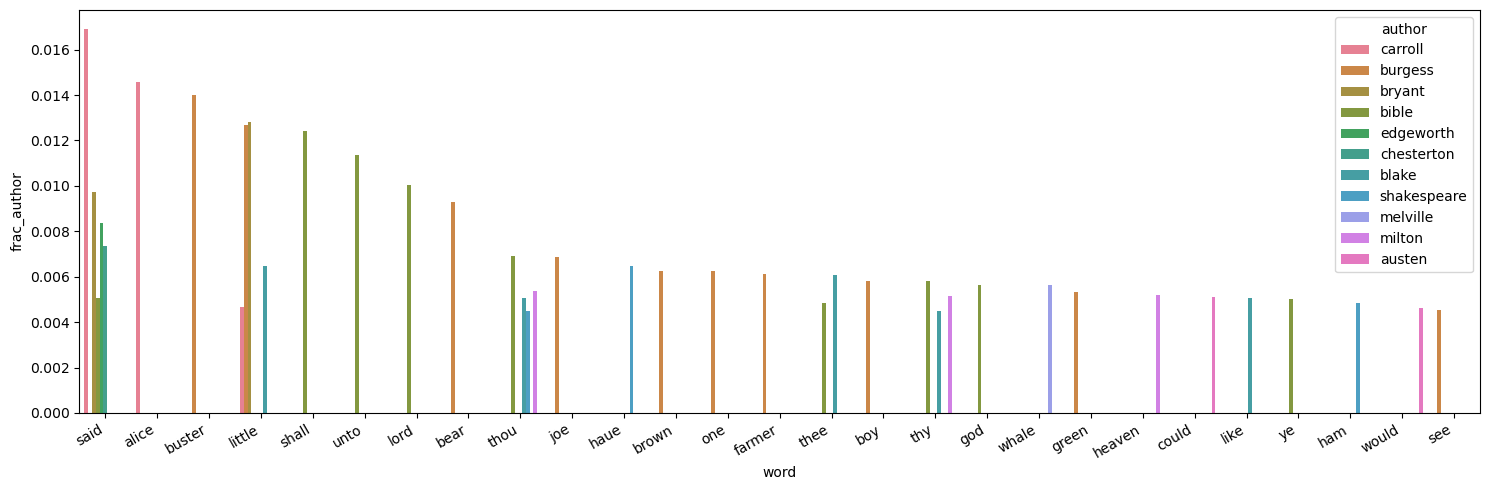

In [13]:
fig, ax = plt.subplots(figsize = (15,5))
sns.barplot(data =  clean_data.sort_values("frac_author", ascending = False).head(50), x = "word", y = "frac_author", hue = "author", ax = ax)
plt.xticks(rotation=30, ha='right')
fig.tight_layout()

Most words are still here, but many character names are not. This is most certainly because these characters only appear in one text by an author with multiple, since names like Alice and Buster from authors with only one text in the dataset are still included in the plot, while names from Shakespeare are absent. Notably, not all authors from the dataset are included in this plot. Specifically I noticed Walt Whitman was missing. At first I though I had made a mistake, but it turns out that no non-stopword words of Whitman's had a high enough fraction. Therefore I shall plot only Whitman's words and see which are most prominent.

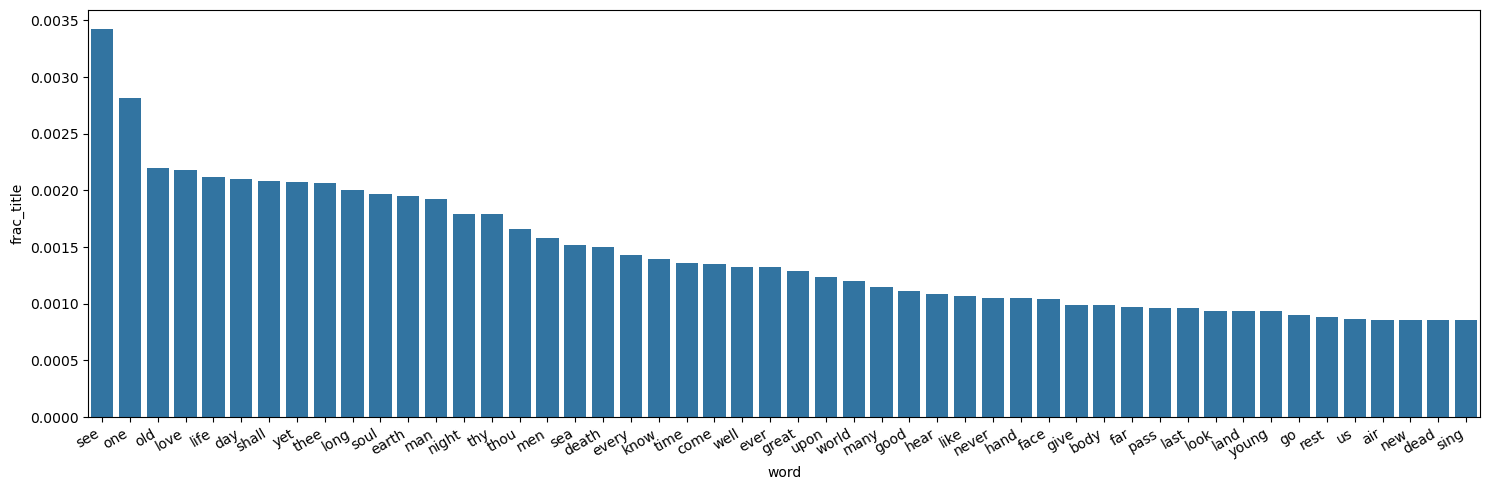

In [14]:
fig, ax = plt.subplots(figsize = (15,5))
sns.barplot(data = clean_data.loc[clean_data["author"] == "whitman"].sort_values("frac_title", ascending = False).head(50), x = "word", y = "frac_title", ax = ax)
plt.xticks(rotation=30, ha='right')
fig.tight_layout()

As Whitman's only work in the data is Leaves of Grass - which is a collection of poems - the subject matter and therefore vocabulary should be quite varied, since each poem will have slightly different vocabulary. This might explain why the most used work in the text is "see" with a `frac_title` value of under 0.0035. The lowest value in the previous two plots was about 0.004. Though there still seems to be some common themes among the poems judging by the appearance of "love", "life", "day" all being very positive, happy words.

Lastly, I'd like to end off with looking at the King James Bible, as that is both a work with a lot of old words, and is the largest work in the dataset by far, with about 37% of the words being from there.

In [15]:
print(sum(df.loc[df["author"] == "bible"]["count"])/sum(df["count"]))
print("that's a lot of words!")

0.3708047272051245
that's a lot of words!


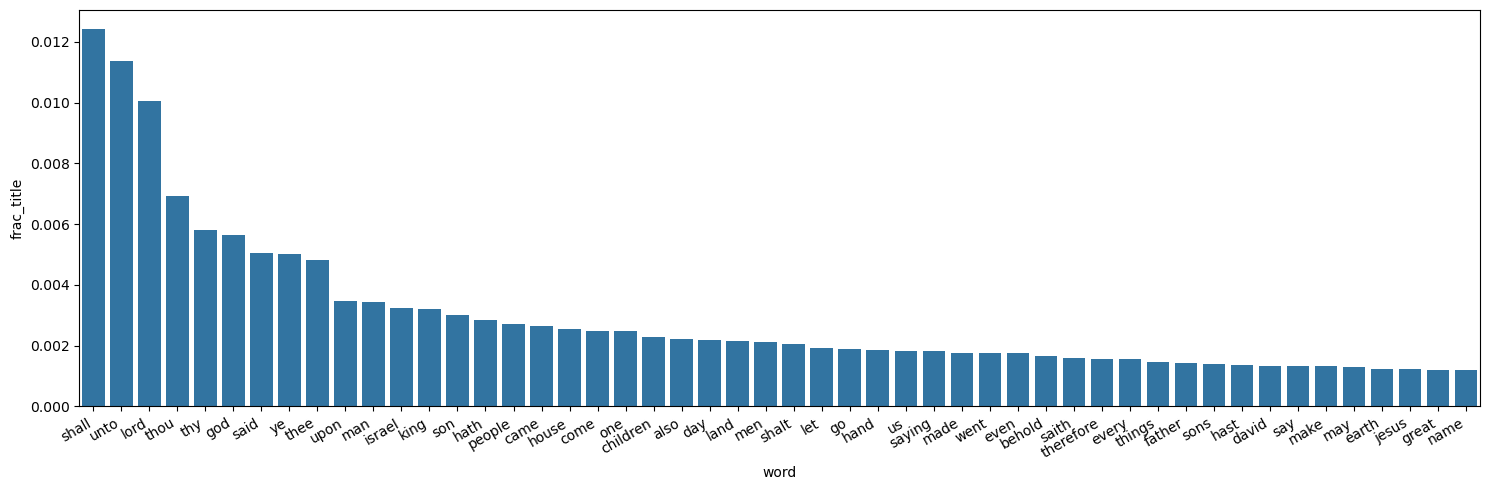

In [16]:
fig, ax = plt.subplots(figsize = (15,5))
sns.barplot(data = clean_data.loc[clean_data["author"] == "bible"].sort_values("frac_title", ascending = False).head(50), x = "word", y = "frac_title", ax = ax)
plt.xticks(rotation=30, ha='right')
fig.tight_layout()

Of course, we see the antiquated words "thou" "thy" "ye" and "thee" at the top. We also see God high up, noticably higher than Jesus, who is third from last place! This should be because Jesus only comes in the new testament, but it's still interesting jesus comes after "son". The top three words are interesting as they are rare words nowadays, they are still real words, unlike "thou" and "thy". The top three are noticably more common than the others. Lord makes sense as that is a synonym for God, but shall and unto being higher up in unexpected. I suppose what god shall do unto things is a very common topic in the Bible.